Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os, re, shutil
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.regularizers import l2,l1,l1_l2
from tensorflow.keras.preprocessing.image import load_img, img_to_array

import matplotlib.pyplot as plt
from glob import glob

In [2]:
# using Tensorflow version 2.8.0
tf.__version__

'2.8.0'

In [3]:
REMOVE_AUGMENTED_FILES = True
AUGMENTOR_IMAGES = 500

In [4]:

def clean_augmented_files(dir_in):
    for root, dirnames, filenames in os.walk(dir_in):
        root = re.sub(r'\\', "/", root)
        if 'output' in root:
            shutil.rmtree(root)
            if not os.path.exists(root):
                print(f"Removed: {root}")

In [5]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [6]:
# BASE_DIR = "d:/nikhil/projects/upgrad/upgrad/projects_assignments/c06_m04_melanoma_cnn_assignment"
BASE_DIR = "."
IMAGES_PATH = f"{BASE_DIR}/Skin cancer ISIC The International Skin Imaging Collaboration"

In [7]:
if REMOVE_AUGMENTED_FILES:
    clean_augmented_files(IMAGES_PATH)

In [8]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path(f"{IMAGES_PATH}/Train")
data_dir_test = pathlib.Path(f"{IMAGES_PATH}/Test")
data_dir_train

WindowsPath('Skin cancer ISIC The International Skin Imaging Collaboration/Train')

In [9]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [10]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [11]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
# train_ds = ##todo
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle = True
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [12]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
# val_ds = ##todo
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle = True
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [13]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names, len(class_names))

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion'] 9


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

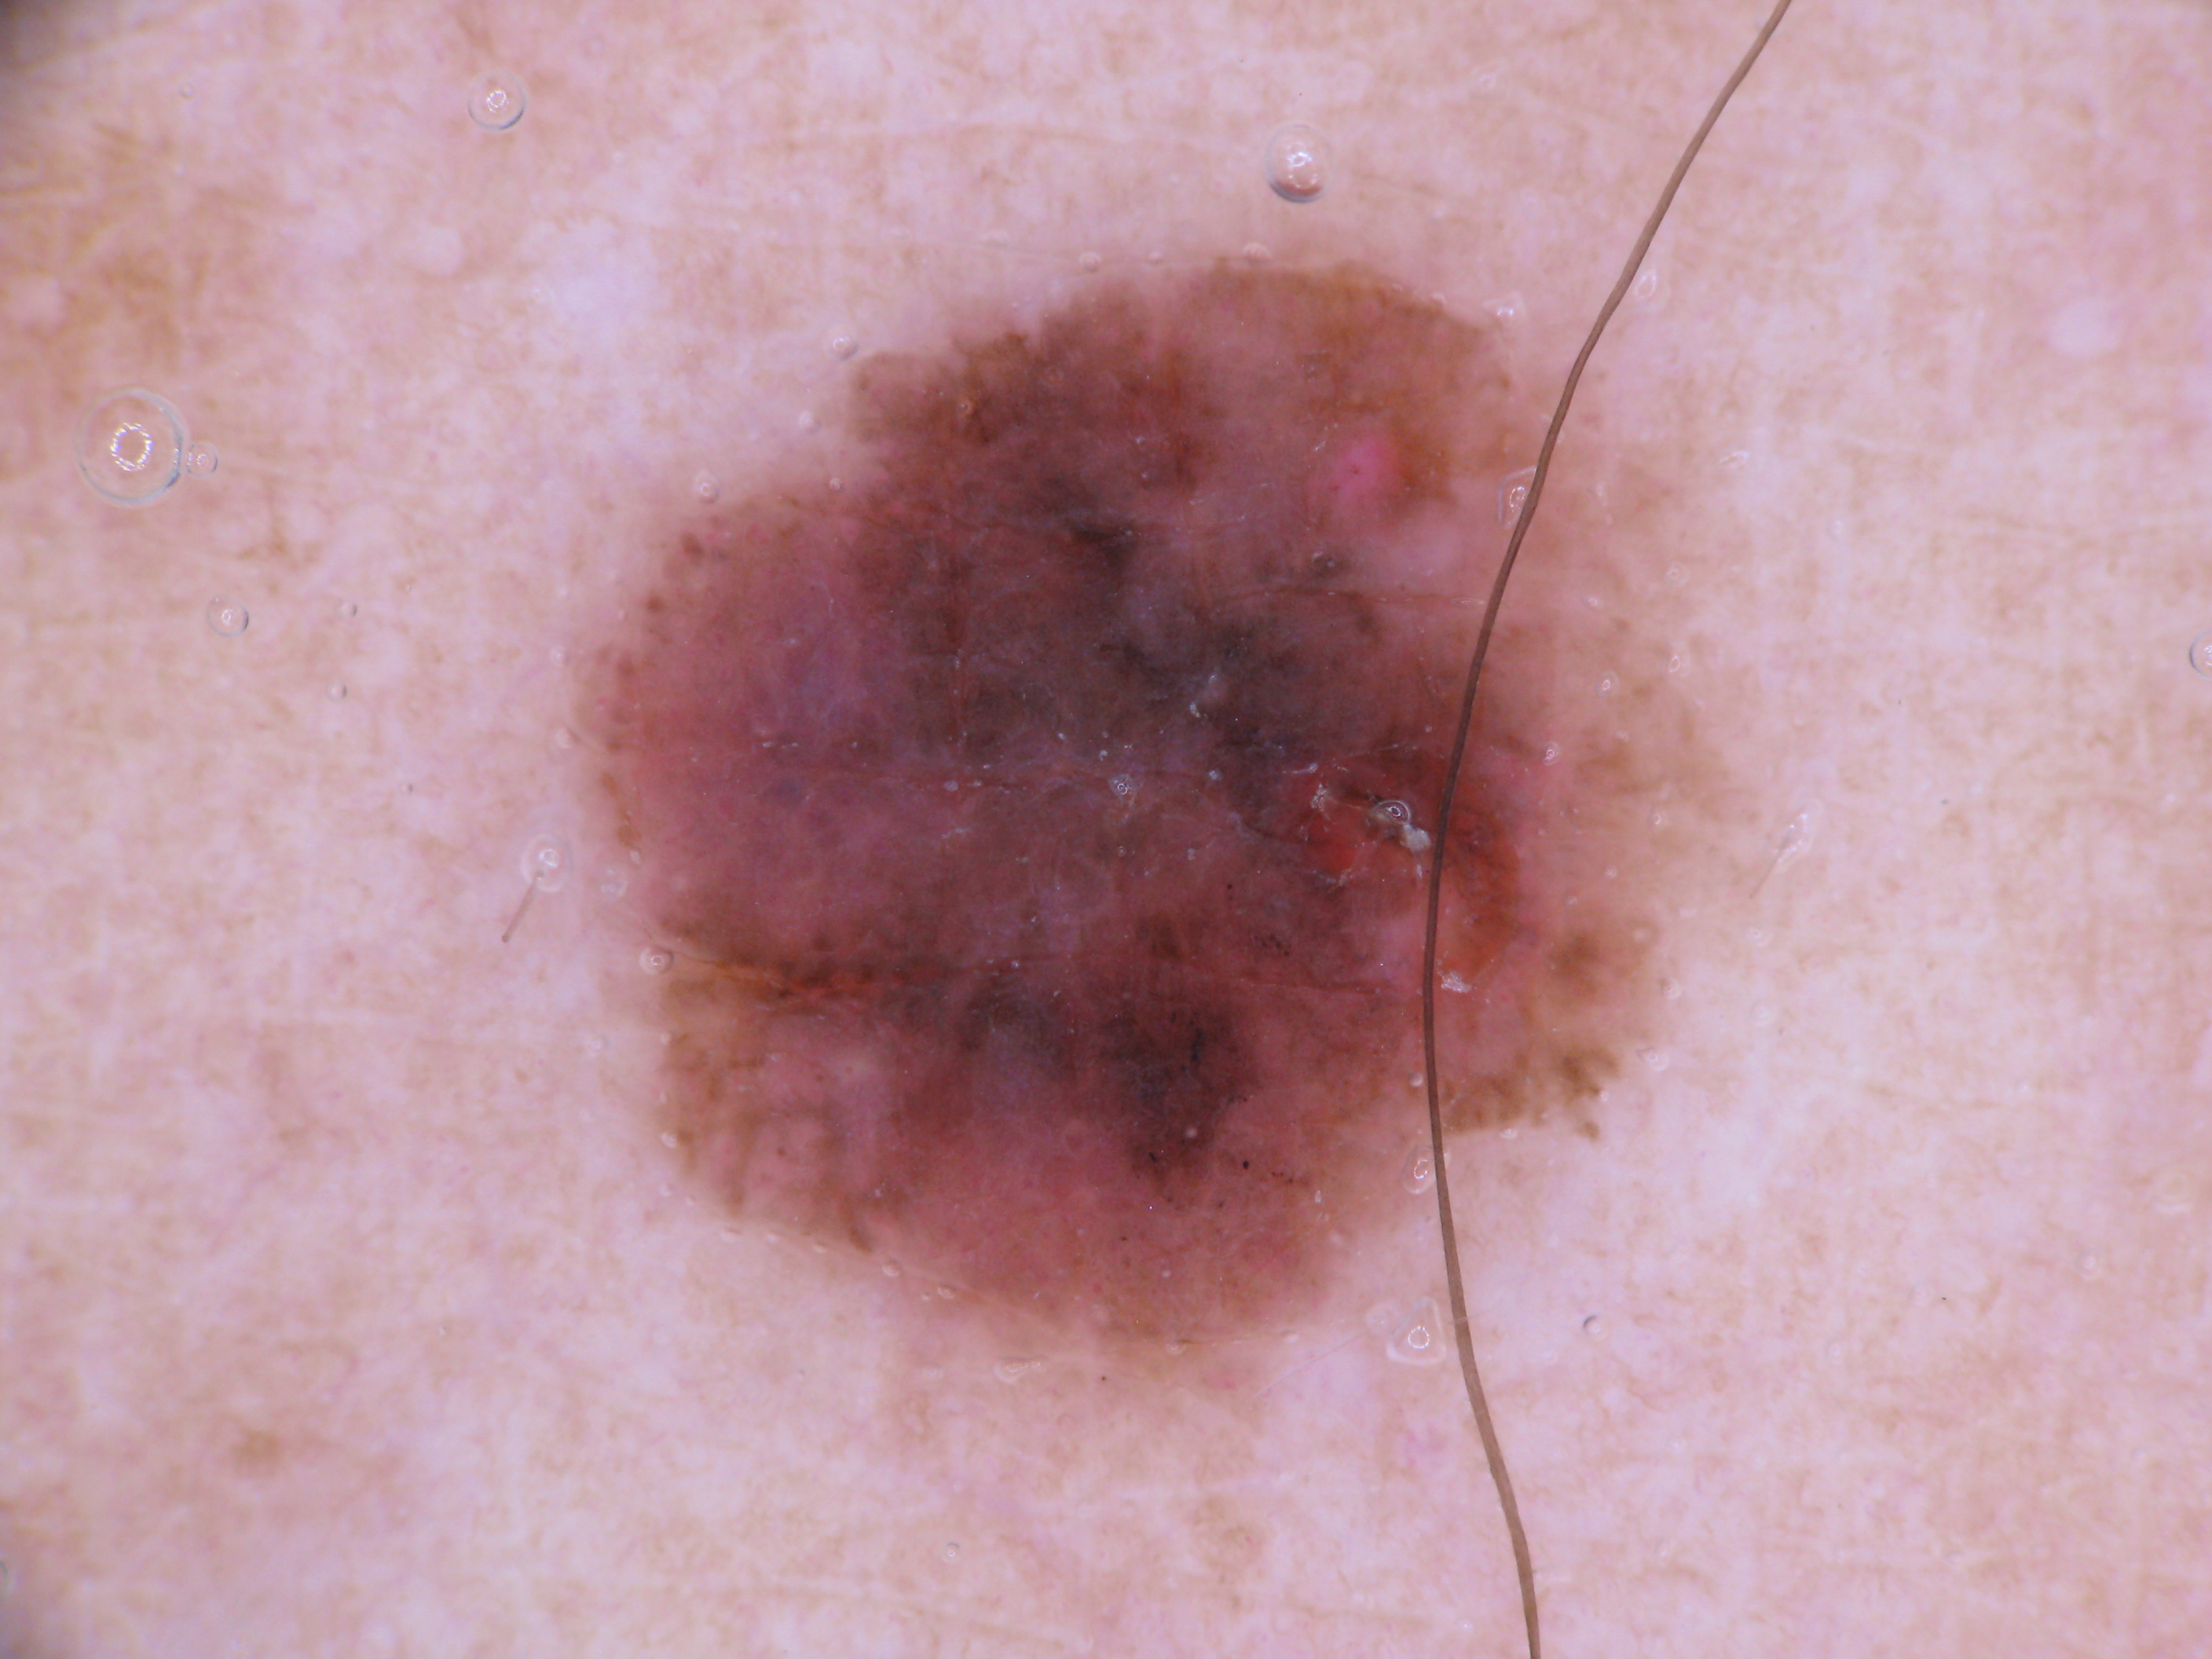

In [14]:
### your code goes here, you can use training or validation data to visualize
melanoma = list(data_dir_train.glob('melanoma/*'))
PIL.Image.open(str(melanoma[0]))

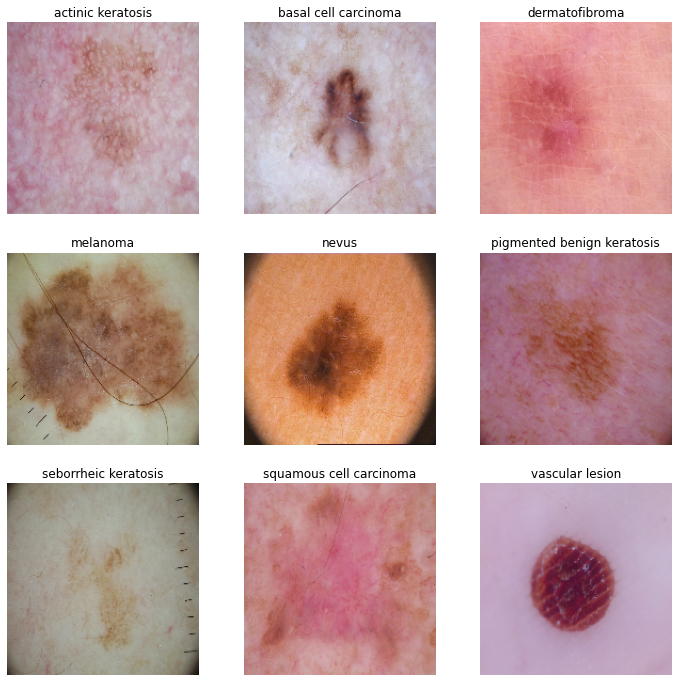

In [15]:
plt.figure(figsize=(12, 12))

j = 0
cnames_temp = class_names.copy()
for images, labels in val_ds:
    for i in range(len(images)):
#         print(j)
        if class_names[labels[i]] == class_names[j]:
            ax = plt.subplot(3, 3, j + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")
            j += 1
            if j == len(class_names):
                break
    if j == len(class_names):
                break
            

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

In [16]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [17]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
AUTOTUNE

-1

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [18]:
def add_conv_block(imodel,
    n_convs=1, n_filts=32, ikernel_size=(3, 3), istrides=1, ipadding="same",
    ialpha=0.05, ipool_size=(2, 2), 
    pool_padding_same=False, bn=0, idropout=0.):

    for i in range(n_convs):
        imodel.add(layers.Conv2D(
            n_filts, kernel_size=ikernel_size, strides=istrides, kernel_initializer="he_normal", padding=ipadding))
        if bn:
            imodel.add(layers.BatchNormalization())
        imodel.add(tf.keras.layers.LeakyReLU(alpha=ialpha))

    if pool_padding_same:
        imodel.add(layers.MaxPooling2D(pool_size=ipool_size, strides=(1, 1), padding="same"))
    else:
        imodel.add(layers.MaxPooling2D(pool_size=ipool_size))
    if idropout > 0:
        imodel.add(layers.Dropout(idropout))


In [19]:
def get_my_model_1():
    num_classes = len(class_names)
    alpha = 0.2
    
    lmodel = Sequential()

    lmodel.add(layers.experimental.preprocessing.Rescaling(1./255., input_shape=(180, 180, 3)))

    add_conv_block(lmodel, 1, 64, ikernel_size=(9, 9), istrides=2, ipadding="same", bn=0)
    add_conv_block(lmodel, 1, 128, ikernel_size=(7, 7), bn=0)
    add_conv_block(lmodel, 2, 256, ikernel_size=(3, 3), bn=0)
    add_conv_block(lmodel, 2, 512, ikernel_size=(3, 3), pool_padding_same=False, bn=0)

    lmodel.add(layers.Flatten())
    
    lmodel.add(layers.Dense(2048, kernel_initializer="he_normal"))
    lmodel.add(tf.keras.layers.LeakyReLU(alpha=alpha))
    
    lmodel.add(layers.Dense(1024, kernel_initializer="he_normal"))
    lmodel.add(tf.keras.layers.LeakyReLU(alpha=alpha))
    
    lmodel.add(layers.Dense(num_classes, activation='softmax'))
    return lmodel

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [20]:
### Todo, choose an appropirate optimiser and loss function
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0001,
    decay_steps=250,
    decay_rate=0.9)

adam = keras.optimizers.Adam(learning_rate=lr_schedule, beta_1=0.9)

sgd = tf.keras.optimizers.SGD(
    learning_rate=lr_schedule, momentum=0.99, nesterov=True
)

model1 = get_my_model_1()
model1.compile(optimizer=adam,
              loss= tf.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 90, 90, 64)        15616     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 90, 90, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 45, 45, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 45, 45, 128)       401536    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 45, 45, 128)       0         
                                                        

### Train the model

In [21]:
epochs = 20
history = model1.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
#     multi_processing=True
)

Epoch 1/20
56/56 [==============================] - 11s 86ms/step - loss: 3.1387 - accuracy: 0.2232 - val_loss: 1.9411 - val_accuracy: 0.3020
Epoch 2/20
56/56 [==============================] - 4s 69ms/step - loss: 1.8129 - accuracy: 0.3326 - val_loss: 1.6869 - val_accuracy: 0.4430
Epoch 3/20
56/56 [==============================] - 4s 70ms/step - loss: 1.5697 - accuracy: 0.4470 - val_loss: 1.4432 - val_accuracy: 0.5056
Epoch 4/20
56/56 [==============================] - 4s 69ms/step - loss: 1.4476 - accuracy: 0.4950 - val_loss: 1.4799 - val_accuracy: 0.5034
Epoch 5/20
56/56 [==============================] - 4s 69ms/step - loss: 1.3467 - accuracy: 0.5385 - val_loss: 1.4132 - val_accuracy: 0.5302
Epoch 6/20
56/56 [==============================] - 4s 69ms/step - loss: 1.2572 - accuracy: 0.5636 - val_loss: 1.3418 - val_accuracy: 0.5459
Epoch 7/20
56/56 [==============================] - 4s 69ms/step - loss: 1.2401 - accuracy: 0.5586 - val_loss: 1.3929 - val_accuracy: 0.5213
Epoch 8/20
5

### Visualizing training results

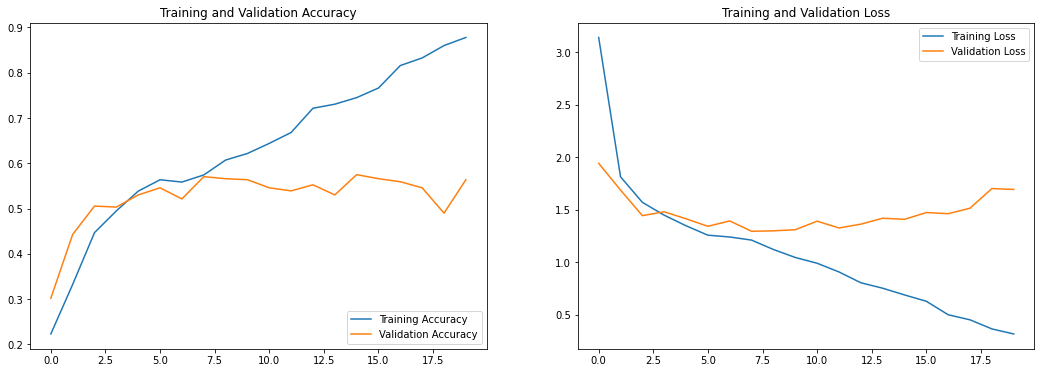

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

- Model seems to be Overfitting
  - Train accuracy increases continuously
  - Validation accuracy increases in the beginning and then it remains constant
- More data might help
- More number of epochs will also help
- Handling class imbalance might help

### Data augmentation - Keras built-in 

In [23]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here

augmentation_layers = [
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", seed=123),
    layers.experimental.preprocessing.RandomZoom(.25, .25, seed=123),
    layers.experimental.preprocessing.RandomRotation(0.25, seed=123)
]

data_augmentation = tf.keras.Sequential()
data_augmentation.add(layers.experimental.preprocessing.Rescaling(1./255., input_shape=(180, 180, 3)))
for al in augmentation_layers:
    data_augmentation.add(al)

#### Visualize data augmentation for a single instance

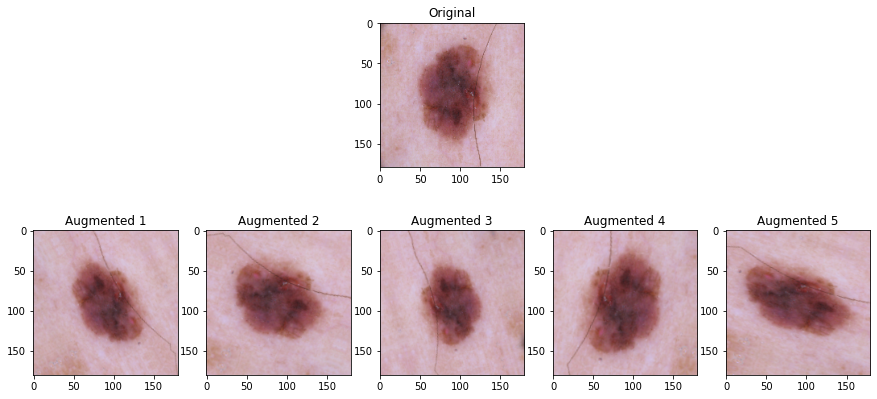

In [24]:
melanoma = list(data_dir_train.glob('melanoma/*'))
img = load_img(str(melanoma[0]), target_size=(180, 180, 3))
xi = img_to_array(img)
image = xi.reshape((1,) + xi.shape)
# image = tf.cast(tf.expand_dims(img, 0), tf.float32)

plt.figure(figsize=(15, 7))
ax2 = plt.subplot(2, 5, 3)
plt.title("Original")
plt.imshow(img)
for i in range(5):
#     print(i)
    augmented_image = data_augmentation(image, training=True)
    ax1 = plt.subplot(2, 5, 5 + i + 1)
    plt.title(f"Augmented {i+1}")
    plt.imshow(augmented_image[0])
#   plt.axis("off")
plt.show()

### Create the model, compile and train the model

In [25]:
def get_my_model_2():
    num_classes = len(class_names)
    alpha = 0.3

    lmodel = Sequential()

    lmodel.add(layers.experimental.preprocessing.Rescaling(1./255., input_shape=(180, 180, 3)))

    for augmentation_layer in augmentation_layers:
        lmodel.add(augmentation_layer)

    add_conv_block(lmodel, 1, 64, ikernel_size=(9, 9), istrides=2, ipadding="same", bn=0)
    add_conv_block(lmodel, 1, 128, ikernel_size=(7, 7), bn=0)
    add_conv_block(lmodel, 2, 256, ikernel_size=(3, 3), bn=0)
    add_conv_block(lmodel, 2, 512, ikernel_size=(3, 3), pool_padding_same=False, bn=0)

    lmodel.add(layers.Flatten())
    
    lmodel.add(layers.Dense(2048, kernel_initializer="he_normal"))
    lmodel.add(tf.keras.layers.LeakyReLU(alpha=alpha))
    
    lmodel.add(layers.Dense(1024, kernel_initializer="he_normal"))
    lmodel.add(tf.keras.layers.LeakyReLU(alpha=alpha))
    
    lmodel.add(layers.Dense(num_classes, activation='softmax'))
    return lmodel


### Compiling the model

In [26]:
### Todo, choose an appropirate optimiser and loss function

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0001,
    decay_steps=250,
    decay_rate=0.9)

adam = keras.optimizers.Adam(learning_rate=lr_schedule, beta_1=0.9)

sgd = tf.keras.optimizers.SGD(
    learning_rate=lr_schedule, momentum=0.99, nesterov=True
)

model2 = get_my_model_2()
model2.compile(optimizer=adam,
              loss= tf.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 random_flip (RandomFlip)    (None, 180, 180, 3)       0         
                                                                 
 random_zoom (RandomZoom)    (None, 180, 180, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 180, 180, 3)      0         
 tion)                                                           
                                                                 
 conv2d_6 (Conv2D)           (None, 90, 90, 64)        15616     
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 90, 90, 64)        0         
                                                      

### Training the model

In [27]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history2 = model2.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
)

Epoch 1/20
56/56 [==============================] - 5s 68ms/step - loss: 2.0862 - accuracy: 0.2712 - val_loss: 1.6260 - val_accuracy: 0.4027
Epoch 2/20
56/56 [==============================] - 4s 64ms/step - loss: 1.6288 - accuracy: 0.4174 - val_loss: 1.5523 - val_accuracy: 0.4743
Epoch 3/20
56/56 [==============================] - 4s 65ms/step - loss: 1.5227 - accuracy: 0.4621 - val_loss: 1.6365 - val_accuracy: 0.4407
Epoch 4/20
56/56 [==============================] - 3s 62ms/step - loss: 1.4796 - accuracy: 0.4771 - val_loss: 1.4214 - val_accuracy: 0.5123
Epoch 5/20
56/56 [==============================] - 3s 63ms/step - loss: 1.3991 - accuracy: 0.5039 - val_loss: 1.3918 - val_accuracy: 0.5213
Epoch 6/20
56/56 [==============================] - 4s 65ms/step - loss: 1.3917 - accuracy: 0.5017 - val_loss: 1.4057 - val_accuracy: 0.5168
Epoch 7/20
56/56 [==============================] - 4s 64ms/step - loss: 1.3453 - accuracy: 0.5201 - val_loss: 1.3570 - val_accuracy: 0.5235
Epoch 8/20
56

### Visualizing the results

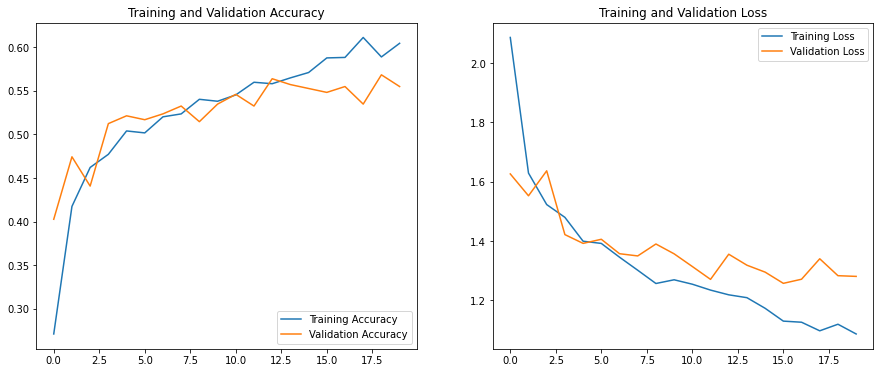

In [28]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?
  
- There is good improvement in overfitting
- But overall accuracy has now decreased
- This means, training for more epochs will help

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

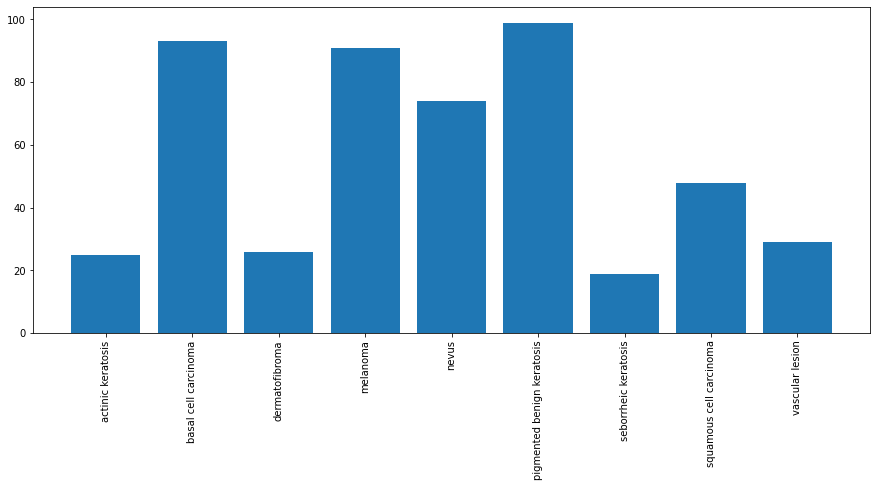

In [29]:
## Your code goes here.

data = dict()

for i in class_names:
  data[i] = []

# plt.figure(figsize=(10, 6))
for images, labels in train_ds:
  for i in range(9):
    data[class_names[labels[i]]].append(images[i].numpy().astype("uint8"))

for i in data:
  data[i] = len(data[i]) 

f = plt.figure()
f.set_figwidth(15)
f.set_figheight(6)

plt.bar(range(len(data)), list(data.values()), align='center')
plt.xticks(range(len(data)), list(data.keys()), rotation=90)
plt.show()

#### Which class has the least number of samples?
#### Which classes dominate the data in terms proportionate number of samples?
- seborrheic keratosis has the least numbers of cells
- pigmented benign keratosis, melanoma and basal cell carcinoma have most samples

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [30]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [31]:
import Augmentor
Augmentor.__version__

'0.2.9'

In [32]:
path_to_training_dataset = f"{IMAGES_PATH}/Train"
import Augmentor

if REMOVE_AUGMENTED_FILES:
    clean_augmented_files(path_to_training_dataset)

for i in class_names:
    print(i, path_to_training_dataset + '/' + i)
    p = Augmentor.Pipeline(path_to_training_dataset + '/' + i)
    p.rotate(probability=0.5, max_left_rotation=25, max_right_rotation=25)
    p.zoom(probability=0.5, min_factor=1.0, max_factor=1.6)
    p.flip_left_right(probability=0.3)
    p.resize(probability=1., width=180, height=180)
    p.sample(AUGMENTOR_IMAGES) ## We are adding samples per class to make sure that none of the classes are sparse.

actinic keratosis ./Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis
Initialised with 114 image(s) found.
Output directory set to ./Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=180x180 at 0x24CC3700100>: 100%|█| 1500/1500 [00:04<00:00, 370.38 Sampl


basal cell carcinoma ./Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma
Initialised with 376 image(s) found.
Output directory set to ./Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=180x180 at 0x24CDB9ABD60>: 100%|█| 1500/1500 [00:03<00:00, 380.80 Sampl


dermatofibroma ./Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma
Initialised with 95 image(s) found.
Output directory set to ./Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma\output.

Processing <PIL.Image.Image image mode=RGB size=180x180 at 0x24CA77129A0>: 100%|█| 1500/1500 [00:04<00:00, 370.23 Sampl


melanoma ./Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma
Initialised with 438 image(s) found.
Output directory set to ./Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=180x180 at 0x24CA76CDD90>: 100%|█| 1500/1500 [00:17<00:00, 87.47 Sample


nevus ./Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus
Initialised with 357 image(s) found.
Output directory set to ./Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus\output.

Processing <PIL.Image.Image image mode=RGB size=180x180 at 0x24C9F1703A0>: 100%|█| 1500/1500 [00:15<00:00, 95.13 Sample


pigmented benign keratosis ./Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis
Initialised with 462 image(s) found.
Output directory set to ./Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=180x180 at 0x24CA7751640>: 100%|█| 1500/1500 [00:03<00:00, 375.74 Sampl


seborrheic keratosis ./Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis
Initialised with 77 image(s) found.
Output directory set to ./Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=180x180 at 0x24CA772B790>: 100%|█| 1500/1500 [00:07<00:00, 188.57 Sampl


squamous cell carcinoma ./Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma
Initialised with 181 image(s) found.
Output directory set to ./Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=180x180 at 0x24CC36B85B0>: 100%|█| 1500/1500 [00:03<00:00, 381.66 Sampl


vascular lesion ./Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion
Initialised with 139 image(s) found.
Output directory set to ./Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion\output.

Processing <PIL.Image.Image image mode=RGB size=180x180 at 0x24AFF355190>: 100%|█| 1500/1500 [00:04<00:00, 361.79 Sampl


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [33]:
data_dir_train_aug = pathlib.Path(f"{IMAGES_PATH}/Train")
image_count_train = len(list(data_dir_train_aug.glob('*/output/*.jpg')))
print(image_count_train)

13500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [34]:

path_list = [x for x in glob(os.path.join(data_dir_train_aug, '*','output', '*.jpg'))]
print(len(path_list))
path_list_orig = [x for x in glob(os.path.join(data_dir_train_aug, '*', '*.jpg'))]
print(len(path_list_orig))
lesion_list_orig = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train_aug, '*', '*.jpg'))]
print(len(lesion_list_orig))
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train_aug, '*','output', '*.jpg'))]
lesion_list_new[0:5]

13500
2239
2239


['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis']

In [35]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))
dataframe_dict_orig = dict(zip(path_list_orig, lesion_list_orig))

In [36]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
original_df = pd.DataFrame(list(dataframe_dict_orig.items()),columns = ['Path','Label'])
new_df = pd.concat([original_df, df2])# original_df.append(df2)
new_df.shape

(15739, 2)

In [37]:
new_df['Label'].value_counts()

pigmented benign keratosis    1962
melanoma                      1938
basal cell carcinoma          1876
nevus                         1857
squamous cell carcinoma       1681
vascular lesion               1639
actinic keratosis             1614
dermatofibroma                1595
seborrheic keratosis          1577
Name: Label, dtype: int64

So, now we have added images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [38]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [39]:
# data_dir_train_aug=pathlib.Path(path_to_training_dataset)
train_ds_aug = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train_aug,
  seed=123,
  validation_split = 0.1,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 15739 files belonging to 9 classes.
Using 14166 files for training.


#### **Todo:** Create a validation dataset

In [40]:
val_ds_aug = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train_aug,
  seed=123,
  validation_split = 0.1,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 15739 files belonging to 9 classes.
Using 1573 files for validation.


In [41]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds_aug = train_ds_aug.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds_aug = val_ds_aug.cache().prefetch(buffer_size=AUTOTUNE)
AUTOTUNE

-1

#### **Todo:** Create your model (make sure to include normalization)

In [42]:
def get_my_model_3():
    num_classes = len(class_names)
    alpha = 0.2
    
    lmodel = Sequential()

    lmodel.add(layers.experimental.preprocessing.Rescaling(1./255., input_shape=(180, 180, 3)))

    add_conv_block(lmodel, 1, 64, ikernel_size=(9, 9), istrides=2, ipadding="same")
    add_conv_block(lmodel, 1, 128, ikernel_size=(7, 7), idropout=0.2)
    add_conv_block(lmodel, 2, 256, ikernel_size=(3, 3), idropout=0.2)
    add_conv_block(lmodel, 2, 512, ikernel_size=(3, 3), pool_padding_same=False, idropout=0.2)

    lmodel.add(layers.Flatten())
    lmodel.add(layers.Dropout(0.3))
    
    lmodel.add(layers.Dense(2048, kernel_initializer="he_normal"))
    lmodel.add(tf.keras.layers.LeakyReLU(alpha=alpha))
    lmodel.add(layers.Dropout(0.3))
    
    lmodel.add(layers.Dense(1024, kernel_initializer="he_normal"))
    lmodel.add(tf.keras.layers.LeakyReLU(alpha=alpha))
    lmodel.add(layers.Dropout(0.3))
    
    lmodel.add(layers.Dense(num_classes, activation='softmax'))
    return lmodel

model3 = get_my_model_3()

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [43]:
## your code goes here
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0001,
    decay_steps=200,
    decay_rate=0.95)

adam = keras.optimizers.Adam(learning_rate=lr_schedule, beta_1=0.9)

model3 = get_my_model_3()
model3.compile(optimizer=adam,
              loss= tf.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model3.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 90, 90, 64)        15616     
                                                                 
 leaky_re_lu_24 (LeakyReLU)  (None, 90, 90, 64)        0         
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 45, 45, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 45, 45, 128)       401536    
                                                                 
 leaky_re_lu_25 (LeakyReLU)  (None, 45, 45, 128)       0         
                                                      

#### **Todo:**  Train your model

In [44]:
# callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
epochs = 30
history_aug = model3.fit(
    train_ds_aug,
    validation_data=val_ds_aug,
    epochs=epochs
)

Epoch 1/30
443/443 [==============================] - 34s 55ms/step - loss: 1.8789 - accuracy: 0.2805 - val_loss: 1.5185 - val_accuracy: 0.4253
Epoch 2/30
443/443 [==============================] - 24s 53ms/step - loss: 1.4835 - accuracy: 0.4265 - val_loss: 1.3348 - val_accuracy: 0.4940
Epoch 3/30
443/443 [==============================] - 23s 52ms/step - loss: 1.3484 - accuracy: 0.4797 - val_loss: 1.2870 - val_accuracy: 0.5111
Epoch 4/30
443/443 [==============================] - 23s 53ms/step - loss: 1.2300 - accuracy: 0.5213 - val_loss: 1.2246 - val_accuracy: 0.5092
Epoch 5/30
443/443 [==============================] - 24s 53ms/step - loss: 1.1294 - accuracy: 0.5638 - val_loss: 0.9941 - val_accuracy: 0.6217
Epoch 6/30
443/443 [==============================] - 23s 52ms/step - loss: 1.0122 - accuracy: 0.6098 - val_loss: 0.9480 - val_accuracy: 0.6135
Epoch 7/30
443/443 [==============================] - 23s 51ms/step - loss: 0.8990 - accuracy: 0.6534 - val_loss: 0.8603 - val_accuracy:

#### **Todo:**  Visualize the model results

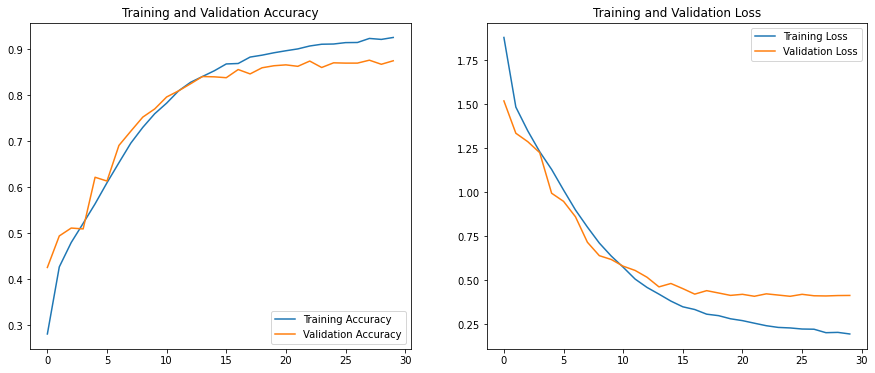

In [45]:
acc = history_aug.history['accuracy']
val_acc = history_aug.history['val_accuracy']

loss = history_aug.history['loss']
val_loss = history_aug.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

- Model 3 was trained for 30 epochs (1500 images) and (500 images)
- Augmentor was used to reduce class imbalance
- __1500 images are generated for each class in addition to 500 images to get better class balance__
- Observations:
    - Final model is still overfitting slightly
    - Validation accuracy is much better than model 1 and model 2
    - Rebalancing classes by increasing number of images helped in increasing accuracy and reducing overfitting
    - Increasing number of epochs also helped

#### Increasing Augmentor images to 1500 per class increases validation accuracy to 86%
#### Increasing images and epochs further will help reduce overfitting